In [1]:
# Connect WRDS
import wrds

db = wrds.Connection(wrds_username='yanqinglin')

Loading library list...
Done


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from pandas_datareader import data as pdr
import datetime
import wrds
import warnings
from scipy.optimize import minimize
warnings.filterwarnings('ignore')

Retrieving Barrick Gold's debt data...
=== Quarterly Debt Data (debt_quarterly) ===
             gvkey   dlttq  dlcq            Lt
datadate                                      
2023-12-31  002055  5180.0  43.0  2633000000.0
2024-03-31  002055  4713.0  12.0  2368500000.0
2024-06-30  002055  4713.0  11.0  2367500000.0
2024-09-30  002055  4712.0  13.0  2369000000.0
2024-12-31  002055  5172.0  84.0  2670000000.0

=== Daily Interpolated Debt Data (daily_debt) ===
                           Lt
2023-12-31       2633000000.0
2024-01-01  2630093406.593407
2024-01-02  2627186813.186813
2024-01-03   2624280219.78022
2024-01-04  2621373626.373626
...                       ...
2024-12-27  2656913043.478261
2024-12-28  2660184782.608696
2024-12-29   2663456521.73913
2024-12-30  2666728260.869565
2024-12-31       2670000000.0

[367 rows x 1 columns]


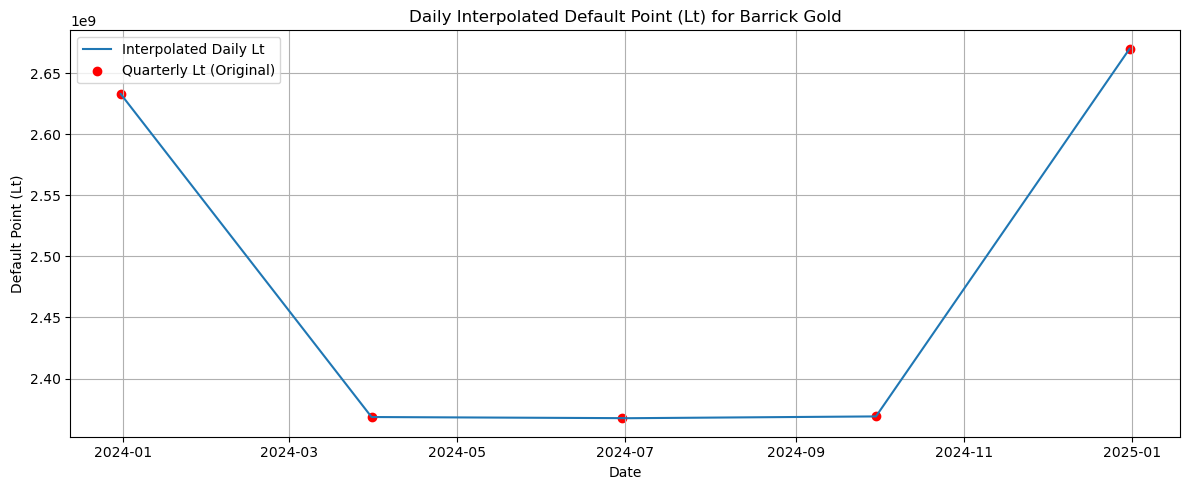

In [3]:
# Question 1
# Retrieve debt data from Compustat for Barrick Gold
print("Retrieving Barrick Gold's debt data...")
query_debt = """
SELECT datadate, gvkey, dlttq, dlcq
FROM comp.fundq
WHERE gvkey = '002055' 
  AND datadate BETWEEN '2023-10-01' AND '2024-12-31'
ORDER BY datadate
"""
debt_quarterly = db.raw_sql(query_debt)

# Convert date column to datetime format
debt_quarterly['datadate'] = pd.to_datetime(debt_quarterly['datadate'])

# Calculate default point Lt as current liabilities + 50% of long-term debt
# dlcq and dlttq are in million USD
debt_quarterly['Lt'] = (debt_quarterly['dlcq'] + 0.5 * debt_quarterly['dlttq']) * 1000000

# Set the date as the index
debt_quarterly.set_index('datadate', inplace=True)

# Create a daily date range covering the period of the available data
daily_dates = pd.date_range(start=debt_quarterly.index.min(), end=debt_quarterly.index.max())
daily_debt = pd.DataFrame(index=daily_dates)

# Join and interpolate quarterly data to get daily values
daily_debt = daily_debt.join(debt_quarterly[['Lt']])
daily_debt = daily_debt.interpolate(method='linear')

# Display the original quarterly debt data
print("=== Quarterly Debt Data (debt_quarterly) ===")
print(debt_quarterly)

# Display the interpolated daily debt data
print("\n=== Daily Interpolated Debt Data (daily_debt) ===")
print(daily_debt)

# Plot the interpolated default point over time
plt.figure(figsize=(12, 5))
plt.plot(daily_debt.index, daily_debt['Lt'], label='Interpolated Daily Lt')
plt.scatter(debt_quarterly.index, debt_quarterly['Lt'], color='red', label='Quarterly Lt (Original)')
plt.title('Daily Interpolated Default Point (Lt) for Barrick Gold')
plt.xlabel('Date')
plt.ylabel('Default Point (Lt)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Retrieving Barrick Gold's stock price and shares outstanding...
=== Daily Market Capitalization ===
               market_cap
2023-10-02  24980309640.0
2023-10-03  24910090920.0
2023-10-04  24927645600.0
2023-10-05  25226075160.0
2023-10-06  25594723440.0
...                   ...
2024-12-27  27409408320.0
2024-12-28  27281218060.0
2024-12-29  27153027800.0
2024-12-30  27024837540.0
2024-12-31  27094759500.0

[457 rows x 1 columns]


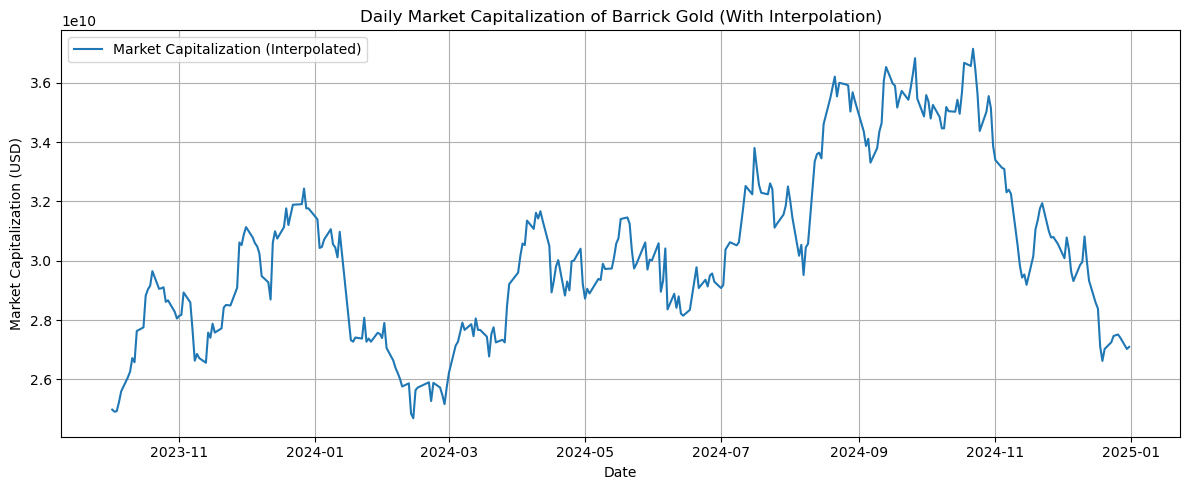

In [4]:
# Question 2
# Get stock price and shares outstanding from CRSP
print("Retrieving Barrick Gold's stock price and shares outstanding...")
query_stock = """
SELECT date, prc, shrout
FROM crsp.dsf
WHERE permno = 71298
  AND date BETWEEN '2023-10-01' AND '2024-12-31'
ORDER BY date
"""
stock_data = db.raw_sql(query_stock)

# Convert date column and clean up
stock_data['date'] = pd.to_datetime(stock_data['date'])
stock_data['prc'] = stock_data['prc'].abs()  # Ensure positive prices
stock_data['shrout'] = stock_data['shrout'] * 1000  # Convert from thousands to shares
stock_data['market_cap'] = stock_data['prc'] * stock_data['shrout']
stock_data.set_index('date', inplace=True)
stock_data = stock_data.sort_index()  # Ensure chronological order

# Keep only market cap
stock_data = stock_data[['market_cap']]

# Reindex to include all calendar days (including weekends & holidays)
full_dates = pd.date_range(start=stock_data.index.min(), end=stock_data.index.max(), freq='D')
stock_data = stock_data.reindex(full_dates)

# Interpolate missing market cap values
# NEED to VERIFY!!!!!
stock_data['market_cap'] = stock_data['market_cap'].interpolate(method='linear')

# Print the daily market capitalization after interpolation
print("=== Daily Market Capitalization ===")
print(stock_data)

# Plot the daily market capitalization time series
plt.figure(figsize=(12, 5))
plt.plot(stock_data.index, stock_data['market_cap'], label='Market Capitalization (Interpolated)')
plt.title('Daily Market Capitalization of Barrick Gold (With Interpolation)')
plt.xlabel('Date')
plt.ylabel('Market Capitalization (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
# Question 3
# Retrieve risk-free rate (1-year zero-coupon yield from St. Louis Fed)
print("Fetching 1-year zero-coupon Treasury yield...")

start_date = debt_quarterly.index.min() - pd.Timedelta(days=30)
end_date = debt_quarterly.index.max()

risk_free_data = pdr.get_data_fred('DGS1', start=start_date, end=end_date)
risk_free_data = risk_free_data / 100  # Convert from percentage to decimal
risk_free_data.index = pd.to_datetime(risk_free_data.index)

# Reindex to include all calendar days (even weekends & holidays)
full_dates = pd.date_range(start=risk_free_data.index.min(), end=risk_free_data.index.max(), freq='D')
risk_free_data = risk_free_data.reindex(full_dates)

# Interpolate missing values
# NEED to VERIFY!!!!!
risk_free_data['DGS1'] = risk_free_data['DGS1'].interpolate(method='linear')

print("Successfully retrieved and interpolated risk-free rate data:")
print(risk_free_data)

# Check again for any remaining NaN
if risk_free_data.isna().any().any():
    print("☹️ Some NaN values remain after interpolation.")
else:
    print("😄 All missing values have been filled by interpolation.")

Fetching 1-year zero-coupon Treasury yield...
Successfully retrieved and interpolated risk-free rate data:
                DGS1
2023-12-01  0.050500
2023-12-02  0.050667
2023-12-03  0.050833
2023-12-04  0.051000
2023-12-05  0.050600
...              ...
2024-12-27  0.042000
2024-12-28  0.041900
2024-12-29  0.041800
2024-12-30  0.041700
2024-12-31  0.041600

[397 rows x 1 columns]
😄 All missing values have been filled by interpolation.


In [6]:
# Ensure all indices are datetime and sorted
stock_data = stock_data.sort_index()
daily_debt = daily_debt.sort_index()
risk_free_data = risk_free_data.sort_index()

# Combine all datasets into one DataFrame by date
data = pd.concat([
    stock_data[['market_cap']],
    daily_debt[['Lt']],
    risk_free_data.rename(columns={'DGS1': 'risk_free_rate'})
], axis=1)

# Trim the data to start from the first date where Lt is available
data = data.loc[data['Lt'].first_valid_index():]

# Display result
print("=== Combined Daily Data ===")
print(data)

=== Combined Daily Data ===
                    market_cap                 Lt  risk_free_rate
2023-12-31       31581660000.0       2633000000.0        0.047950
2024-01-01       31489470000.0  2630093406.593407        0.047975
2024-01-02       31397280000.0  2627186813.186813        0.048000
2024-01-03  30431479999.999996   2624280219.78022        0.048100
2024-01-04  30466600000.000004  2621373626.373626        0.048500
...                        ...                ...             ...
2024-12-27       27409408320.0  2656913043.478261        0.042000
2024-12-28       27281218060.0  2660184782.608696        0.041900
2024-12-29       27153027800.0   2663456521.73913        0.041800
2024-12-30       27024837540.0  2666728260.869565        0.041700
2024-12-31       27094759500.0       2670000000.0        0.041600

[367 rows x 3 columns]


In [7]:
from tqdm import tqdm

def merton_model(asset, debt, rf, sigma, t=1):
    """
    Calculate equity value using the Merton model
    
    Parameters:
    asset: Asset value
    debt: Debt face value
    rf: Risk-free rate
    sigma: Asset volatility
    t: Time to maturity in years
    
    Returns:
    Equity value according to the Merton model
    """
    d1 = (np.log(asset / debt) + (rf + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    return asset * norm.cdf(d1) - debt * np.exp(-rf * t) * norm.cdf(d2)

def asset_value_row(row, sigma, t=1):
    """
    Calculate implied asset value for a single row using the Merton model
    
    Parameters:
    row: DataFrame row containing market_cap, Lt, and risk_free_rate
    sigma: Asset volatility
    t: Time to maturity in years
    
    Returns:
    Implied asset value
    """
    equity = row['market_cap']
    debt = row['Lt']
    rf = row['risk_free_rate']
    
    # Define the objective function: we want merton_model(asset, ...) == equity
    objective = lambda asset: merton_model(asset, debt, rf, sigma, t) - equity
    initial_guess = equity + debt  # A common initial guess: equity plus debt
    
    # Use a timeout to prevent excessive computation
    asset = fsolve(objective, initial_guess, xtol=1e-6, maxfev=100)[0]
    return asset

def vectorized_asset_values(data, sigma, t=1):
    """
    Calculate asset values for all rows more efficiently
    
    This function applies asset_value_row to each row but can be optimized
    further with actual vectorization if the structure allows.
    """
    # This could be optimized further if merton_model can be truly vectorized
    assets = []
    for _, row in tqdm(data.iterrows(), total=len(data), desc="Calculating asset values", disable=True):
        try:
            asset_value = asset_value_row(row, sigma, t)
            assets.append(asset_value)
        except:
            # Handle potential errors in fsolve
            assets.append(np.nan)
    
    return pd.Series(assets, index=data.index)

def calculate_merton_model(data, max_iterations=50, tolerance=1e-10):
    """
    Run the Merton model iterations until convergence
    
    Parameters:
    data: DataFrame containing market_cap, Lt, and risk_free_rate
    max_iterations: Maximum number of iterations to perform
    tolerance: Convergence tolerance for sigma
    
    Returns:
    Tuple of (asset_values, final_sigma, convergence_history)
    """
    # Make a copy of the data to avoid modifying the original
    data = data.copy()
    
    # Initialize variables
    data['log_return'] = np.log(data['market_cap'] / data['market_cap'].shift(1))
    sigma_0 = data['log_return'].std() * np.sqrt(252)
    
    iteration = 0
    converged = False
    
    print(f"Starting with initial sigma: {sigma_0:.6f}")
    
    # Main iteration loop - continue until convergence
    while not converged and iteration < max_iterations:
        iteration += 1
        
        # Step 1: Calculate asset values using current sigma
        data['asset_value'] = vectorized_asset_values(data, sigma=sigma_0, t=1)
        
        # Step 2: Calculate log returns from these asset values
        data['asset_log_return'] = np.log(data['asset_value'] / data['asset_value'].shift(1))
        
        # Step 3: Calculate new sigma as standard deviation of log returns
        # Drop NaN values that might appear in the first row or from errors
        sigma_1 = data['asset_log_return'].dropna().std() * np.sqrt(252)
        
        # Record convergence history
        sigma_diff = abs(sigma_1 - sigma_0)
        
        # Step 4: Check convergence
        if sigma_diff < tolerance:
            converged = True
            print(f"Converged after {iteration} iterations!")
        else:
            # Update sigma for next iteration
            sigma_0 = sigma_1
    
    if not converged:
        print(f"Failed to converge after {max_iterations} iterations.")
    
    # Final calculation with the converged sigma
    final_assets = vectorized_asset_values(data, sigma=sigma_1, t=1)
    final_asset_value = final_assets.iloc[-1]

    print(f"Estimated Asset Volatility (yearly): {sigma_1:.6f}")
    print(f"Estimated Asset Value at 2024-12-31: {final_asset_value:.2f} USD")
    
    return final_assets, sigma_1

In [8]:
asset_values, final_sigma = calculate_merton_model(data, max_iterations=20, tolerance=1e-6)

Starting with initial sigma: 0.246115
Converged after 2 iterations!
Estimated Asset Volatility (yearly): 0.228657
Estimated Asset Value at 2024-12-31: 29655966091.90 USD


=== Default Frontier (Quarterly) ===
                           0             1                  2   \
datadate                                                         
2023-12-31  2498947368.421052  2633000000.0  2767052631.578948   
2024-03-31  2245105263.157895  2368500000.0  2491894736.842105   
2024-06-30  2244052631.578948  2367500000.0  2490947368.421052   
2024-09-30  2245684210.526316  2369000000.0  2492315789.473684   
2024-12-31  2538315789.473684  2670000000.0  2801684210.526316   

                           3                  4                  5   \
datadate                                                              
2023-12-31  2901105263.157895  3035157894.736842  3169210526.315789   
2024-03-31   2615289473.68421  2738684210.526316  2862078947.368421   
2024-06-30  2614394736.842105  2737842105.263158   2861289473.68421   
2024-09-30  2615631578.947369  2738947368.421052  2862263157.894737   
2024-12-31  2933368421.052631  3065052631.578948  3196736842.105263   

  

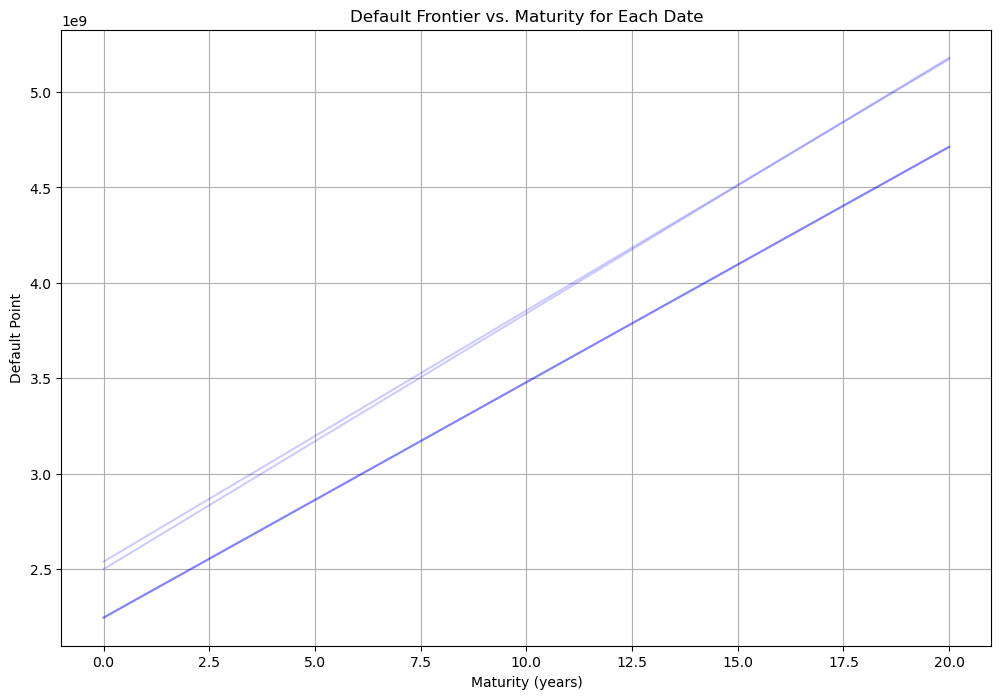

In [9]:
# Question 4
# Create an array of maturities from 0 to 20 years (you can use a finer step if needed)
maturities = np.arange(0, 21, 1)

# Construct a DataFrame with dates as the index and maturities as the column labels
default_frontier = pd.DataFrame(index=debt_quarterly.index, columns=maturities)

# For each maturity, compute the default point using linear interpolation between Lt and dlttq
for m in maturities:
    default_frontier[m] = debt_quarterly['Lt'] + ((m - 1) / (20 - 1)) * (debt_quarterly['dlttq'] * 1000000 - debt_quarterly['Lt'])

# Display a portion of the data
print("=== Default Frontier (Quarterly) ===")
print(default_frontier)

# Create a new figure for the plot
plt.figure(figsize=(12, 8))

# Loop over each date in the default_frontier DataFrame and plot the default frontier line
for date in default_frontier.index:
    plt.plot(maturities, default_frontier.loc[date, :], color='blue', alpha=0.2)

plt.title("Default Frontier vs. Maturity for Each Date")
plt.xlabel("Maturity (years)")
plt.ylabel("Default Point")
plt.grid(True)
plt.show()

In [10]:
# Question 5
# Organize the data
# Map each maturity (in years) to its corresponding FRED series code
fred_series = {
    1: "DGS1",    # 1-year zero-coupon yield
    2: "DGS2",    # 2-year zero-coupon yield
    3: "DGS3",    # 3-year zero-coupon yield
    5: "DGS5",    # 5-year zero-coupon yield
    7: "DGS7",    # 7-year zero-coupon yield
    10: "DGS10",  # 10-year zero-coupon yield
    20: "DGS20"   # 20-year zero-coupon yield
}

# Set the target date for which you want to retrieve data
target_date = "2024-12-31"

# Fetch data for each series from FRED, restricted to the target date
rf_data = {}
for maturity, series in fred_series.items():
    data = pdr.get_data_fred(series, start=target_date, end=target_date)
    if not data.empty:  # Check if any data was returned
        rf_data[maturity] = data[series].iloc[0]

# Convert the dictionary into a DataFrame for easier viewing
df = pd.DataFrame(rf_data.items(), columns=['Maturity', 'Yield'])

# Default Frontier for 2024-12-31
default_frontier = default_frontier.loc['2024-12-31']

df['Default Frontier'] = df['Maturity'].map(default_frontier)

# Asset value and volatility on 2024-12-31
asset_value = asset_values.iloc[-1]
volatility = final_sigma
recovery_rate = 0.4  # 40% recovery rate (standard assumption) NEED double check！！！

Credit Spread Term Structure:
   Maturity  Risk_Free_Rate  Default_Barrier  Default_Probability  \
0         1            4.16     2.670000e+09         1.541164e-24   
1         2            4.25     2.801684e+09         6.934076e-12   
2         3            4.27     2.933368e+09         1.208651e-07   
3         5            4.38     3.196737e+09         2.958343e-04   
4         7            4.48     3.460105e+09         8.258446e-03   
5        10            4.58     3.855158e+09         9.890970e-02   
6        20            4.86     5.172000e+09         1.589390e+00   

   Credit_Spread_bps  
0      -0.000000e+00  
1       2.081668e-10  
2       2.417303e-06  
3       3.550015e-03  
4       7.078844e-02  
5       5.936344e-01  
6       4.791051e+00  


([<matplotlib.axis.XTick at 0x158ca1880>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(10, 0, '10'),
  Text(20, 0, '20')])

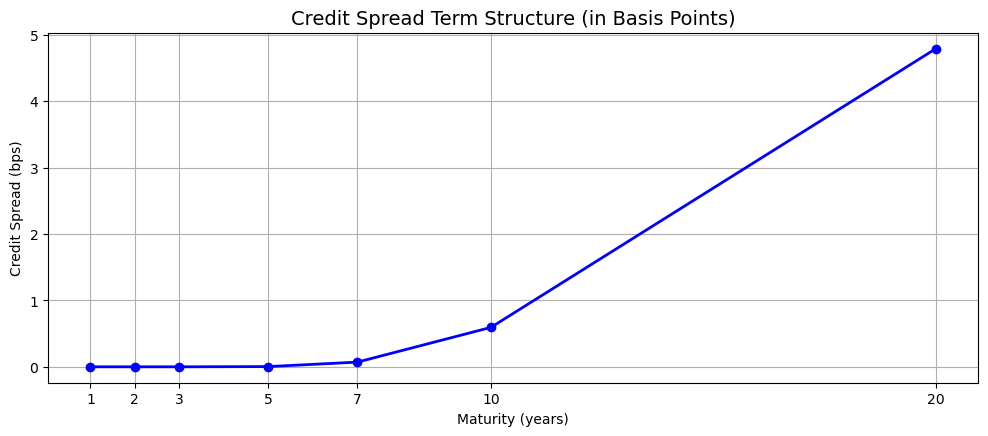

In [11]:
# Define the Merton model function to compute the default probability
def merton_default_probability(asset_value, default_barrier, rf, sigma, T):
    """
    Calculate the default probability using the Merton model.
    
    Parameters:
    asset_value: The firm's asset value.
    default_barrier: The default barrier (usually the face value of debt).
    rf: The risk-free rate.
    sigma: The asset volatility.
    T: The time to maturity (in years).
    
    Returns:
    The default probability.
    """
    d2 = (np.log(asset_value / default_barrier) + (rf - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(-d2)

# Define a function to calculate the credit spread based on default probability
def calculate_credit_spread(default_prob, recovery_rate, T):
    """
    Calculate the credit spread based on the default probability.
    
    Parameters:
    default_prob: The default probability.
    recovery_rate: The recovery rate.
    T: The time to maturity (in years).
    
    Returns:
    The credit spread (in basis points).
    """
    # Standard formula: s ≈ -ln(1 - LGD*PD) / T
    # where LGD = 1 - recovery_rate, and PD = default_prob
    LGD = 1 - recovery_rate
    
    # Prevent taking log of non-positive numbers
    if default_prob * LGD >= 1:
        return float('inf')
    
    # Multiply by 10,000 to convert to basis points
    return -np.log(1 - LGD * default_prob) / T * 10000

# Calculate credit spreads and default probabilities for each maturity term
results = []

for _, row in df.iterrows():
    maturity = row['Maturity']
    # Convert the risk-free yield from percentage to decimal
    rf = row['Yield'] / 100
    barrier = row['Default Frontier']
    
    # Compute the default probability using the Merton model function
    default_prob = merton_default_probability(asset_value, barrier, rf, volatility, maturity)
    
    # Compute the credit spread based on the default probability and recovery rate
    credit_spread = calculate_credit_spread(default_prob, recovery_rate, maturity)
    
    results.append({
        'Maturity': maturity,
        'Risk_Free_Rate': rf * 100,  # Convert back to percentage for display
        'Default_Barrier': barrier,
        'Default_Probability': default_prob * 100,  # Express as a percentage
        'Credit_Spread_bps': credit_spread
    })

# Convert the results list to a DataFrame
credit_spreads = pd.DataFrame(results)

# Print the credit spread term structure
print("Credit Spread Term Structure:")
print(credit_spreads)

# Visualize the term structure
plt.figure(figsize=(12, 10))

# Plot the credit spread (in basis points) versus maturity
plt.subplot(2, 1, 1)
plt.plot(credit_spreads['Maturity'], credit_spreads['Credit_Spread_bps'], 'b-o', linewidth=2)
plt.title('Credit Spread Term Structure (in Basis Points)', fontsize=14)
plt.xlabel('Maturity (years)')
plt.ylabel('Credit Spread (bps)')
plt.grid(True)
plt.xticks(df['Maturity'])